## ML Pipeline

The procedure goes as follows:

1. Convert categorical variables into dummy variables.
2. Standarize features using StandardScaler.
3. Classify data into two categories: risk=0 or risk!=0.
4. If risk!=0 then classify the observation into risk=-1 or risk!=-1.
5. If risk!=-1 then use a regression algorithm to predict the risk value.

In [337]:
# Import the data
import pandas as pd
df = pd.read_csv('./contest_public/train.csv')

### Preprocessing Class

In [338]:
# Scales the continuous variables of the DataFrame of battery instances and creates dummie variables for the categorical
class BatteryDataframeProcessor:
    def __init__(self):
        # Import packages
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        # Standard Scaler Object
        self.scaler = StandardScaler()
        # Fixed variables. Depending on DataFrame structure
        self.categorical_nominal_features = None
        self.continuous_features_filter = None
        self.dummy_cols_set_train = None
        
    def fit(self, df):
        try:
            self.scaler.mean_
            print("Already fitted battery data to BatteryDataScaler.")
        except:
            # Array of categorical nominal features. batt_instance has primary and secondary. However secondary can be multiple (more than 2) uses
            self.categorical_nominal_features = ['event_country_code', 'batt_manufacturer', 'batt_instance']
            # Continuous features filter
            self.continuous_features_filter = (df.columns != 'event_country_code') & (df.columns != 'batt_manufacturer') & (df.columns != 'batt_instance') & (df.columns != 'risk')
            # Split dataframe into three: categorical and continuous variables and predictor variable.
            df_cont_vars = df.loc[:, self.continuous_features_filter]
            # Fit scaler 
            self.scaler.fit(df_cont_vars.values)
            
    def transform(self, df, is_test_set=False):
        try:
            self.scaler.mean_
            # Split dataframe into three: categorical and continuous variables and predictor variable.
            df_cont_vars = df.loc[:, self.continuous_features_filter]
            df_cat_vars_dummies = pd.get_dummies(df.loc[:, self.categorical_nominal_features], drop_first=True)
            # Scale continuous variables
            x_cont_scaled = self.scaler.transform(df_cont_vars.values)
            # Create a dataframe of the continuous scaled variables
            df_cont_vars_scaled = pd.DataFrame(data=x_cont_scaled, columns = df_cont_vars.columns, index=df_cont_vars.index)
            # Concatenate dataframes back up
            if is_test_set==False:
                # Save dummy columns of train data set
                self.dummy_cols_set_train = set(df_cat_vars_dummies.columns)
                # Return processed dataframe
                return pd.concat([df_cont_vars_scaled, df_cat_vars_dummies, df.loc[:, 'risk']], axis=1)
            else:
                # Only include dummy columns which also appear on the train set. 
                # Since they are categorical there is no way to compare new values
                dummy_cols_set_test = set(df_cat_vars_dummies.columns)
                # Columns that are in the test and train set
                cols_intersection = self.dummy_cols_set_train & dummy_cols_set_test
                # Columns that are in the train set but not in the test set
                cols_only_in_train = self.dummy_cols_set_train - dummy_cols_set_test
                # Only save the ones that are in the intersection
                df_cat_vars_dummies = df_cat_vars_dummies[list(cols_intersection)]
                # Add up the ones that are not in the test set but that are on the train set
                for col in list(cols_only_in_train): df_cat_vars_dummies[col] = 0
                # Return processed dataframe
                return pd.concat([df_cont_vars_scaled, df_cat_vars_dummies], axis=1)
        except:
            print("The processor fit method must be called first.")

### Heat Map Plot

In [339]:
def plot_heatmap(cv_model, param_grid, col_name, row_name, title):
    # Convert scores to dataframe content for heatmap
    df_content = []
    row = []
    num_rows = len(param_grid[row_name])
    for i, score in enumerate(cv_model.cv_results_['mean_test_score']):
        row.append(score) 
        # Add to df_content every num_rows
        if ((i+1)%num_rows == 0) and (i > 0):
            df_content.append(row)
            row = []
    # Columns
    cols = param_grid[row_name]
    # Rows
    rows = param_grid[col_name]
    # Create dataframe for heatmap
    df = pd.DataFrame(data=df_content, columns=cols, index=rows)
    # Create heatmap
    import seaborn as sns
    import matplotlib.pyplot as plt
    ax = plt.axes()
    # Show heatmap
    sns.heatmap(df, ax=ax)
    ax.set_title(title)
    ax.set_ylabel(col_name)
    ax.set_xlabel(row_name)
    plt.show()

### Normal Distribution Plot

In [340]:
def plot_normal_dist(mu, sigma, xlabel, title):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.mlab as mlab
    import math
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x,mlab.normpdf(x, mu, sigma))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Probability Density')
    plt.show()

### Data Preprocessing

In [341]:
# Initialize BatteryDataFrameProcessor
processor = BatteryDataframeProcessor()
# Fit BatteryDataFrameProcessor
processor.fit(df)
# Preprocess the train and test dataframes so that categorical values get dummied and continuous get standard scaled
df_processed = processor.transform(df)

/Users/pedroatencio/anaconda/envs/py361/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The data warning shows up because StandardScaler is notitying that maybe the variable 'installed_count' could
be categorical. Even though 'installed_count' ony spans the values 1 and 2 it could be possibly more. The specifications don't say that this are all the permitted values, thus it is treated inside the scaler.

### PCA Analysis

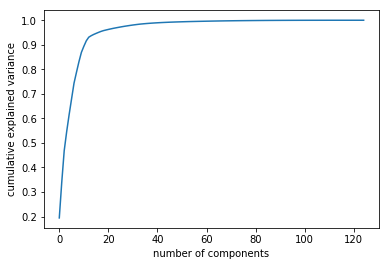

In [342]:
%matplotlib inline
# Explore PCA option
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca = PCA()
X = df_processed.loc[:, df_processed.columns != 'risk'].values
pca.fit(X)
cum_sum_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_sum_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [343]:
print("At 50 principal components the cumulative variance is: {0:1.2%}".format(cum_sum_variance[50]))

At 50 principal components the cumulative variance is: 99.37%


Further exloration with PCA was done as stated in the report. Along with this methods and others. However it did not gave better results than the ones here stated.

### F_1 Optimization

In [344]:
# Import modules
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

In [345]:
# Get X and y
X = df_processed.loc[:, df_processed.columns != 'risk'].values
y = df_processed.loc[:, 'risk'].map(lambda x: 1 if x==0 else 0).values
# Set X_train, X_test, y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

F1 Score: 0.9981072555205047
Tuned Model Parameters: {'max_depth': 20, 'min_samples_split': 6}
Standard Deviation Test Scores: [ 0.00507132  0.00546062  0.00561788  0.00169385  0.0018936   0.00291815
  0.00203632  0.00220574  0.00308415]
Standard Deviation Train Scores: [ 0.00152014  0.00156126  0.00158415  0.00062006  0.00040949  0.00018795
  0.00074317  0.00052723  0.00011515]


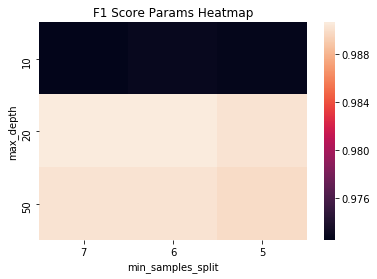

In [346]:
# Import module
from sklearn.tree import DecisionTreeClassifier
# Initialize SVC model
model = DecisionTreeClassifier(random_state=42)
# Param grid for GridSearchCV
param_grid = {'max_depth':[10, 20, 50],
              'min_samples_split':[7, 6, 5]}
# Initialize GridSearchCV
cv = GridSearchCV(model, param_grid, cv=5, scoring='f1', return_train_score=True)
# Fit GridSearchCV. Find optimal.
cv.fit(X, y)
# Predict
y_pred = cv.predict(X_test)
# Metrics
print("F1 Score: {}".format(cv.score(X_test, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))
# Check how robust the model is checking the standard deviations of the scores
print("Standard Deviation Test Scores: {}".format(cv.cv_results_['std_test_score']))
print("Standard Deviation Train Scores: {}".format(cv.cv_results_['std_train_score']))
# Plot heatmap
plot_heatmap(cv, param_grid, 'max_depth', 'min_samples_split', 'F1 Score Params Heatmap')

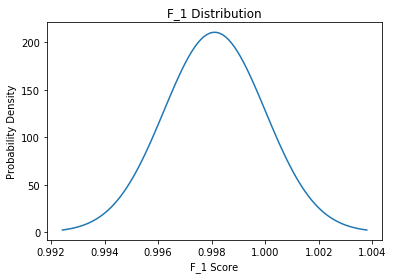

In [347]:
# Plot normal distribution of scores
plot_normal_dist(cv.score(X_test, y_test), cv.cv_results_['std_test_score'][4], 'F_1 Score', 'F_1 Distribution')

### Custom MRAE Optimization

In [348]:
# Mean relative absolute error function
def custom_mrae(y_test, y_pred):
    import numpy as np
    # Get relative difference
    ary = np.abs((y_test - y_pred)*1.0/y_pred)
    # Set the max to one for each value
    ary[np.where(ary > 1)] = 1
    # Get the mean
    return np.mean(ary)
# Loss function. Since custom_mrae goes from 0 to 1
def custom_loss_func(y_test, y_pred):
    return 1-custom_mrae(y_test, y_pred)

In [349]:
# Get the samples where risk != 0 and risk != -1
df_processed_two = df_processed[df_processed['risk'] > 0]
# Get X and y
X_two = df_processed_two.loc[:, df_processed_two.columns != 'risk'].values
y_two = df_processed_two.loc[:, 'risk'].values
# Set X_train, X_test, y_train and y_test
X_two_train, X_two_test, y_two_train, y_two_test = train_test_split(X_two, y_two, test_size=0.2, random_state=42)

Custom MRAE Based Score: 0.9819763478431613
Custom MRAE: 0.018023652156838658
Tuned Model Parameters: {'max_depth': 30, 'min_samples_split': 4}
Standard Deviation Test Scores: [ 0.00422636  0.003982    0.00419071  0.00260117  0.00202027  0.0020589
  0.00170697  0.0011235   0.00115203  0.00170697  0.0011235   0.00115203
  0.00170697  0.0011235   0.00115203]
Standard Deviation Train Scores: [ 0.00202345  0.00199752  0.00198439  0.00076494  0.00083422  0.00098813
  0.00070621  0.00061224  0.00053627  0.00070621  0.00061224  0.00053627
  0.00070621  0.00061224  0.00053627]


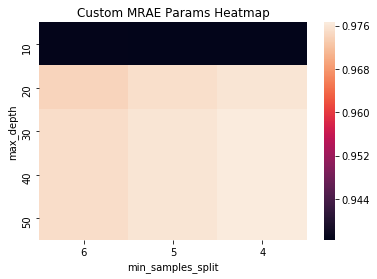

In [350]:
# Import module
from sklearn.tree import DecisionTreeRegressor
# Initialize SVC model
model_two = DecisionTreeRegressor(random_state=42)
# Param grid for GridSearchCV
param_grid_two = {'max_depth':[10, 20, 30, 40, 50],
              'min_samples_split':[6, 5, 4]}
# Make scorer function
from sklearn.metrics import make_scorer
mrae_based_score = make_scorer(custom_loss_func, greater_is_better=True)
# Initialize GridSearchCV
cv_two = GridSearchCV(model_two, param_grid_two, cv=5, scoring=mrae_based_score, return_train_score=True)
# Fit GridSearchCV. Find optimal.
cv_two.fit(X_two_train, y_two_train)
# Predict
y_two_pred = cv_two.predict(X_two_test)
# Metrics
print("Custom MRAE Based Score: {}".format(cv_two.score(X_two_test, y_two_test)))
print("Custom MRAE: {}".format(custom_mrae(y_two_test, y_two_pred)))
print("Tuned Model Parameters: {}".format(cv_two.best_params_))
# Check how robust the model is checking the standard deviations of the scores
print("Standard Deviation Test Scores: {}".format(cv_two.cv_results_['std_test_score']))
print("Standard Deviation Train Scores: {}".format(cv_two.cv_results_['std_train_score']))
# Plot heatmap
plot_heatmap(cv_two, param_grid_two, 'max_depth', 'min_samples_split', 'Custom MRAE Params Heatmap')

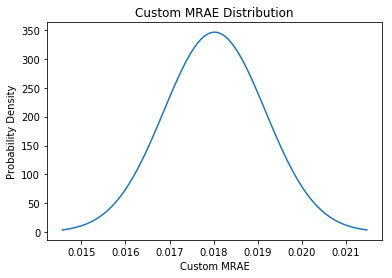

In [351]:
plot_normal_dist(custom_mrae(y_two_test, y_two_pred), cv_two.cv_results_['std_test_score'][8], 'Custom MRAE', 'Custom MRAE Distribution')

### Final Score

In [352]:
# Final score
print("Final Score: {}".format(cv.score(X_test, y_test) + 1 - custom_mrae(y_two_test, y_two_pred)))

Final Score: 1.9800836033636662


### Test Set Predictions

You can change the test set file in the following line of code.

In [353]:
# Read test.csv
df_test = pd.read_csv('./contest_public/test.csv')
# Preprocess dataset
df_test_processed = processor.transform(df_test, is_test_set=True)
# Data test set
X_test_set = df_test_processed.values

/Users/pedroatencio/anaconda/envs/py361/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


The data warning shows up because StandardScaler is notitying that maybe the variable 'installed_count' could
be categorical. Even though 'installed_count' ony spans the values 1 and 2 it could be possibly more. The specifications don't say that this are all the permitted values, thus it is treated inside the scaler.

In [354]:
# Predict if risk = 0 or risk != 0
pred = cv.predict(X_test_set)
# Get indices where risk = 0. That is, for those whose pred = 1
indices_bad = np.argwhere(pred == 1).flatten()
# Get indices where risk != 0. That is, for those whose pred = 0
indices_not_bad = np.argwhere(pred == 0).flatten()
# Predict for those that have risk != 0
pred_not_bad = cv_two.predict(X_test_set[indices_not_bad])
# Set final predictions
pred[indices_not_bad] = pred_not_bad
pred[indices_bad] = 0
# Print stats
print("Of the {0} samples {1}({2:1.1%}) are predicted as having risk = 0 and {3}({4:1.1%}) as having risk != 0.".
     format(len(pred), sum(pred==0), sum(pred==0)/len(pred), sum(pred!=0), sum(pred!=0)/len(pred)))

Of the 15268 samples 136(0.9%) are predicted as having risk = 0 and 15132(99.1%) as having risk != 0.


In [355]:
# Save predictions to a predictions.csv file
df_pred = pd.DataFrame(data=pred, columns=['RISK'])
df_pred.to_csv('predictions.csv', index=False)
# Remove last line as it is a blank space
with open('predictions.csv') as f:
    lines = f.readlines()
    last = len(lines) - 1
    lines[last] = lines[last].replace('\r','').replace('\n','')
with open('predictions.csv', 'w') as wr:
    wr.writelines(lines)